# Group Facilitator : <font color = blue> RAJESH SUGURU </font>
# Team : <font color = blue> RAJESH SUGURU </font> and <font color = blue> VIGNESHWAR RAMAYI </font>

# Ref : https://learn.upgrad.com/v/course/498/module/31215

# Assignment: <font color = blue> C5 : Neural Networks Project - Gesture Recognition</font>


# Problem Statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:
 
| <font color = blue>Gesture</font> | <font color = blue>Corresponding Action</font> |
| --- | --- | 
| **Thumbs Up** | <font color = green>Increase the volume.</font> |
| **Thumbs Down** | <font color = green>Decrease the volume.</font> |
| **Left Swipe** | <font color = green>'Jump' backwards 10 seconds.</font> |
| **Right Swipe** | <font color = green>'Jump' forward 10 seconds.</font> |
| **Stop** | <font color = green>Pause the movie.</font> |

Each video is a sequence of 30 frames (or images).

### Objectives:
1. **Generator**:  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

2. **Model**: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

3. **Write up**: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model. 

In [1]:
# Importing the necessary libraries

import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)
#tf.random.set_seed

Using TensorFlow backend.


In [3]:
import cv2
import matplotlib.pyplot as plt
% matplotlib inline

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
# importing some other libraries which will be needed for model building.

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout

In [5]:
project_folder='Project_data'

##### Plotting

In [6]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
class ModelBuilder(metaclass= abc.ABCMeta):
    # initialisng the path where project data resides
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
    # initialising the image properties    
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
    # initialising the batch size, frames to sample and the no. of epochs
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    # MOST IMPORTANT PART HERE - The generator function        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx):
                #performing image reading and resizing
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            
                #normalizing the images
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    # cropping the images to have the targeted gestures and remove the noise from the images.
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Sample Model

In [23]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        #optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [24]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=1)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation_9 (Activation)    (None, 30, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 30, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 15, 80, 80, 32)    4128      
_________________________________________________________________
activation_10 (Activation)   (None, 15, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 15, 80, 80, 32)    128       
__________

##### Sample Cropping

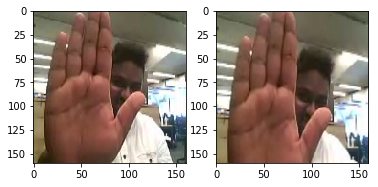

In [25]:
test_generator=ModelConv3D1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])   
axes[1].imshow(batch_data[3,15,:,:,:])   

## Experimenting with 

>> - Image Resolution
>> - Number of Frames to use 
>> - Batch Size

In [26]:
conv_3d1.train_model(conv_3d1_model)

Epoch 1/1
67/67 [==============================] - 98s 1s/step - loss: 1.6307 - categorical_accuracy: 0.3836 - val_loss: 2.0780 - val_categorical_accuracy: 0.3700

Epoch 00001: val_loss improved from inf to 2.07803, saving model to model_init_2020-09-1910_09_52.925487/model-00001-1.62032-0.38763-2.07803-0.37000.h5


### We had encountered Out Of Memory (OOM) of resources with 

>> - Image Resolution : 160x160 
>> - Number of Frames : 30 
>> - Batch Size : 40

### Error Message :

ResourceExhaustedError: OOM when allocating tensor with shape[40,16,30,160,160] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc

In [27]:
print("Memory util is {} Gigs". format(getsizeof(np.zeros((40,16,30,160,160)))/(1024*1024*1024)))

Memory util is 3.662109524011612 Gigs


##### So lets experiment between these parameters

##### Sample experiments to draw inferences on how training time affects by 

>> - Image resolution, 
>> - Number of Images in sequence and 
>> - Batch Size

In [30]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=20,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
34/34 [==============================] - 80s 2s/step - loss: 1.5767 - categorical_accuracy: 0.4172 - val_loss: 1.4103 - val_categorical_accuracy: 0.4900

Epoch 00001: val_loss improved from inf to 1.41033, saving model to model_init_2020-09-1910_13_08.784803/model-00001-1.59093-0.41931-1.41033-0.49000.h5
Epoch 2/2
34/34 [==============================] - 71s 2s/step - loss: 1.1840 - categorical_accuracy: 0.5416 - val_loss: 1.0032 - val_categorical_accuracy: 0.6300

Epoch 00002: val_loss improved from 1.41033 to 1.00318, saving model to model_init_2020-09-1910_13_08.784803/model-00002-1.16679-0.55505-1.00318-0.63000.h5


In [31]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
45/45 [==============================] - 93s 2s/step - loss: 1.6469 - categorical_accuracy: 0.3837 - val_loss: 1.8191 - val_categorical_accuracy: 0.3800

Epoch 00001: val_loss improved from inf to 1.81908, saving model to model_init_2020-09-1910_15_45.924833/model-00001-1.62982-0.38462-1.81908-0.38000.h5
Epoch 2/2
45/45 [==============================] - 82s 2s/step - loss: 1.2858 - categorical_accuracy: 0.5140 - val_loss: 1.1068 - val_categorical_accuracy: 0.5000

Epoch 00002: val_loss improved from 1.81908 to 1.10680, saving model to model_init_2020-09-1910_15_45.924833/model-00002-1.29498-0.51131-1.10680-0.50000.h5


In [32]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
23/23 [==============================] - 55s 2s/step - loss: 1.6556 - categorical_accuracy: 0.3847 - val_loss: 1.7800 - val_categorical_accuracy: 0.4000

Epoch 00001: val_loss improved from inf to 1.78001, saving model to model_init_2020-09-1910_18_48.832319/model-00001-1.64717-0.39970-1.78001-0.40000.h5
Epoch 2/2
23/23 [==============================] - 42s 2s/step - loss: 1.0130 - categorical_accuracy: 0.6042 - val_loss: 1.3207 - val_categorical_accuracy: 0.5300

Epoch 00002: val_loss improved from 1.78001 to 1.32072, saving model to model_init_2020-09-1910_18_48.832319/model-00002-1.01944-0.60181-1.32072-0.53000.h5


- As we see from the above experiments **"Image Resolution"** and **Number of Frames** in sequence have more impact on training time than **Batch Size**
- We can chose the Batch Size around 15-40
- We will change the resoulution 160\*160, 120*120 according the model performance


## Model 1
### Base Model 

>> - Batch Size = 40 and 
>> - Number of Epochs = 15

In [33]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [34]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_33 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_33 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_43 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_33 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_34 (Conv3D)           (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_34 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_44 (Batc (None, 10, 80, 80, 32)    128       
__________

In [35]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061
Epoch 1/15
17/17 [==============================] - 72s 4s/step - loss: 1.4329 - categorical_accuracy: 0.4665 - val_loss: 2.7846 - val_categorical_accuracy: 0.3000

Epoch 00001: val_loss improved from inf to 2.78460, saving model to model_init_2020-09-1910_20_34.195669/model-00001-1.43981-0.46305-2.78460-0.30000.h5
Epoch 2/15
17/17 [==============================] - 51s 3s/step - loss: 0.9787 - categorical_accuracy: 0.5942 - val_loss: 1.0812 - val_categorical_accuracy: 0.6000

Epoch 00002: val_loss improved from 2.78460 to 1.08120, saving model to model_init_2020-09-1910_20_34.195669/model-00002-0.98159-0.59276-1.08120-0.60000.h5
Epoch 3/15
17/17 [==============================] - 57s 3s/step - loss: 0.7447 - categorical_accuracy: 0.7101 - val_loss: 0.9986 - val_categorical_accuracy: 0.6100

Epoch 00003: val_loss improved from 1.08120 to 0.99859, saving model to model_init_2020-09-1910_20_34.195669/model-00003-0.74525-0.71041-0.99859-0.61000.h5
Epoch 4/15
17/17 [=

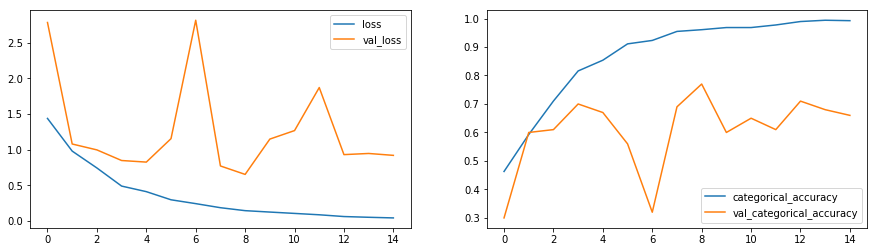

In [36]:
plot(history_model1)

##### Model is clearly overfitting. :(

## Model 2  
>> ### Adding dropout layers 
>> - Batch Size = 20 and 
>> - Number of Epochs = 25

In [37]:
conv_3d2=ModelConv3D1()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=160,image_width=160)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25)
conv_3d2_model=conv_3d2.define_model(dense_neurons=256,dropout=0.5)
conv_3d2_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_37 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_37 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_49 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_37 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_38 (Conv3D)           (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_38 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_50 (Batc (None, 10, 80, 80, 32)    128       
__________

In [38]:
print("Total Params:", conv_3d2_model.count_params())
history_model2=conv_3d2.train_model(conv_3d2_model,augment_data=True)

Total Params: 3638981
Epoch 1/25
34/34 [==============================] - 142s 4s/step - loss: 1.9478 - categorical_accuracy: 0.3812 - val_loss: 7.7224 - val_categorical_accuracy: 0.2300

Epoch 00001: val_loss improved from inf to 7.72243, saving model to model_init_2020-09-1910_35_29.267190/model-00001-1.92366-0.39065-7.72243-0.23000.h5
Epoch 2/25
34/34 [==============================] - 125s 4s/step - loss: 1.3672 - categorical_accuracy: 0.5239 - val_loss: 5.3485 - val_categorical_accuracy: 0.2600

Epoch 00002: val_loss improved from 7.72243 to 5.34850, saving model to model_init_2020-09-1910_35_29.267190/model-00002-1.37085-0.52036-5.34850-0.26000.h5
Epoch 3/25
34/34 [==============================] - 133s 4s/step - loss: 1.4622 - categorical_accuracy: 0.5074 - val_loss: 5.1697 - val_categorical_accuracy: 0.2400

Epoch 00003: val_loss improved from 5.34850 to 5.16969, saving model to model_init_2020-09-1910_35_29.267190/model-00003-1.42973-0.50754-5.16969-0.24000.h5
Epoch 4/25
34/34

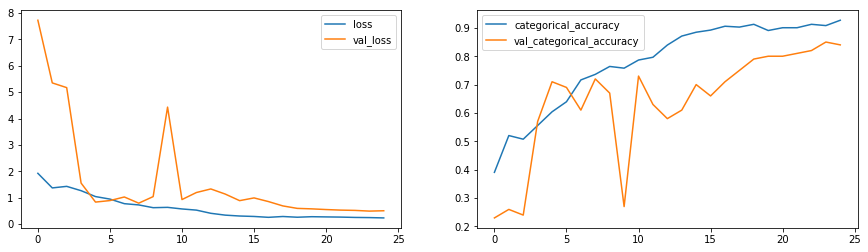

In [39]:
plot(history_model2)

##### One of the best Models with 
>> - Training Accuracy of 0.90
>> - Validation Accuracy of 0.85

## Model 3 
>> ### Reduce filter size to (2,2,2) and image res to 120 x  120
>> - Batch Size = 30 and 
>> - Number of Epochs = 25

In [40]:
class ModelConv3D3(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))
        
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [41]:
conv_3d3=ModelConv3D3()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image_properties(image_height=120,image_width=120)
conv_3d3.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=25)
conv_3d3_model=conv_3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d3_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_41 (Conv3D)           (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_41 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_55 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_41 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_42 (Conv3D)           (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_42 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_56 (Batc (None, 8, 60, 60, 32)     128       
__________

In [42]:
print("Total Params:", conv_3d3_model.count_params())
history_model3=conv_3d3.train_model(conv_3d3_model,augment_data=True)

Total Params: 1762613
Epoch 1/25
23/23 [==============================] - 95s 4s/step - loss: 2.2576 - categorical_accuracy: 0.2883 - val_loss: 1.4320 - val_categorical_accuracy: 0.4900

Epoch 00001: val_loss improved from inf to 1.43201, saving model to model_init_2020-09-1911_31_20.903636/model-00001-2.27174-0.28658-1.43201-0.49000.h5
Epoch 2/25
23/23 [==============================] - 81s 4s/step - loss: 1.6508 - categorical_accuracy: 0.4617 - val_loss: 1.3382 - val_categorical_accuracy: 0.5100

Epoch 00002: val_loss improved from 1.43201 to 1.33825, saving model to model_init_2020-09-1911_31_20.903636/model-00002-1.57138-0.47964-1.33825-0.51000.h5
Epoch 3/25
23/23 [==============================] - 87s 4s/step - loss: 1.4402 - categorical_accuracy: 0.5177 - val_loss: 1.1207 - val_categorical_accuracy: 0.5800

Epoch 00003: val_loss improved from 1.33825 to 1.12072, saving model to model_init_2020-09-1911_31_20.903636/model-00003-1.40037-0.52489-1.12072-0.58000.h5
Epoch 4/25
23/23 [=

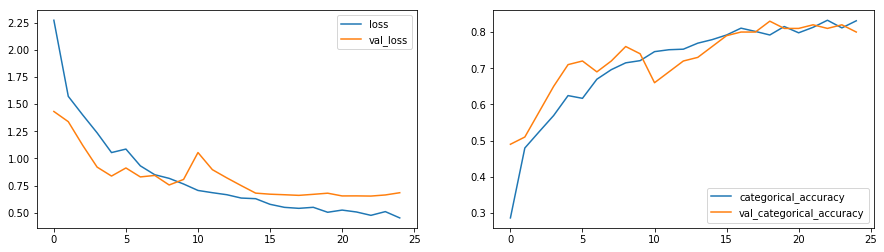

In [43]:
plot(history_model3)

##### Model has a  best validation accuracy of 81% and training accuracy of 83% . Also we were able to reduce the parameter size by half the earlier model. Let's trying adding more layers

## Model 4 - 
>> ### Adding more layers 
>> - Batch Size = 20 and 
>> - Number of Epochs = 25

In [44]:
class ModelConv3D4(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [45]:
conv_3d4=ModelConv3D4()
conv_3d4.initialize_path(project_folder)
conv_3d4.initialize_image_properties(image_height=120,image_width=120)
conv_3d4.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d4_model=conv_3d4.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d4_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_45 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_45 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_61 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_46 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_46 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_62 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_45 (MaxPooling (None, 8, 60, 60, 16)     0         
__________

In [46]:
print("Total Params:", conv_3d4_model.count_params())
history_model4=conv_3d4.train_model(conv_3d4_model,augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 [==============================] - 120s 4s/step - loss: 2.0750 - categorical_accuracy: 0.3657 - val_loss: 12.1385 - val_categorical_accuracy: 0.2300

Epoch 00001: val_loss improved from inf to 12.13855, saving model to model_init_2020-09-1912_08_15.807000/model-00001-2.06247-0.36652-12.13855-0.23000.h5
Epoch 2/25
34/34 [==============================] - 96s 3s/step - loss: 1.6314 - categorical_accuracy: 0.4294 - val_loss: 2.2265 - val_categorical_accuracy: 0.4400

Epoch 00002: val_loss improved from 12.13855 to 2.22650, saving model to model_init_2020-09-1912_08_15.807000/model-00002-1.60205-0.43590-2.22650-0.44000.h5
Epoch 3/25
34/34 [==============================] - 96s 3s/step - loss: 1.3721 - categorical_accuracy: 0.5224 - val_loss: 2.1033 - val_categorical_accuracy: 0.4900

Epoch 00003: val_loss improved from 2.22650 to 2.10329, saving model to model_init_2020-09-1912_08_15.807000/model-00003-1.32856-0.52715-2.10329-0.49000.h5
Epoch 4/25
34/

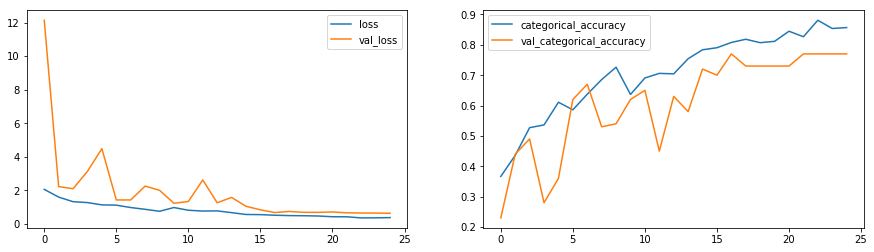

In [47]:
plot(history_model4)

##### With more layers we dont see much performance improvement. We get a best validation accuracy of 77% . Let's try adding dropouts at the convolution layers

## Model 5 
### Adding dropout at convolution layers

In [48]:
class ModelConv3D5(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [49]:
conv_3d5=ModelConv3D5()
conv_3d5.initialize_path(project_folder)
conv_3d5.initialize_image_properties(image_height=120,image_width=120)
conv_3d5.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=15)
conv_3d5_model=conv_3d5.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d5_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_53 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_53 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_71 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_54 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_54 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_72 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_49 (MaxPooling (None, 8, 60, 60, 16)     0         
__________

In [50]:
print("Total Params:", conv_3d5_model.count_params())
history_model5=conv_3d5.train_model(conv_3d5_model,augment_data=True)

Total Params: 2556533
Epoch 1/15
34/34 [==============================] - 111s 3s/step - loss: 1.8315 - categorical_accuracy: 0.3212 - val_loss: 2.0133 - val_categorical_accuracy: 0.4400

Epoch 00001: val_loss improved from inf to 2.01331, saving model to model_init_2020-09-1912_50_23.563036/model-00001-1.82012-0.32504-2.01331-0.44000.h5
Epoch 2/15
34/34 [==============================] - 97s 3s/step - loss: 1.4019 - categorical_accuracy: 0.4562 - val_loss: 1.2851 - val_categorical_accuracy: 0.5100

Epoch 00002: val_loss improved from 2.01331 to 1.28506, saving model to model_init_2020-09-1912_50_23.563036/model-00002-1.40991-0.45098-1.28506-0.51000.h5
Epoch 3/15
34/34 [==============================] - 97s 3s/step - loss: 1.2178 - categorical_accuracy: 0.5379 - val_loss: 1.7371 - val_categorical_accuracy: 0.5300

Epoch 00003: val_loss did not improve from 1.28506
Epoch 4/15
34/34 [==============================] - 97s 3s/step - loss: 1.0714 - categorical_accuracy: 0.5854 - val_loss: 0

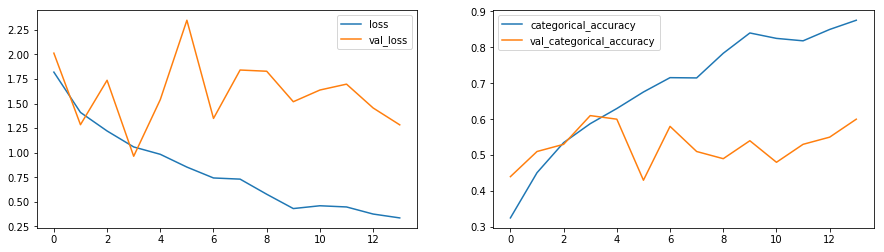

In [51]:
plot(history_model5)

 __Ohh! Overfitting again!! Adding dropouts has further reduced validation accuracy as the model doesn't seem to generalise well. Validation Loss not improved and early stopping of the model at Epoch 14__

##### All the experimental models above have more than 1 million parameters. Let's try to reduce the model size and see the performance

## Model 6 
### Reducing the number of parameters

In [52]:
class ModelConv3D6(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [53]:
conv_3d6=ModelConv3D6()
conv_3d6.initialize_path(project_folder)
conv_3d6.initialize_image_properties(image_height=100,image_width=100)
conv_3d6.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=20)
conv_3d6_model=conv_3d6.define_model(dense_neurons=128,dropout=0.25)
conv_3d6_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_61 (Conv3D)           (None, 16, 100, 100, 16)  1312      
_________________________________________________________________
activation_61 (Activation)   (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_81 (Batc (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_53 (MaxPooling (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_62 (Conv3D)           (None, 8, 50, 50, 32)     4128      
_________________________________________________________________
activation_62 (Activation)   (None, 8, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_82 (Batc (None, 8, 50, 50, 32)     128       
__________

In [54]:
print("Total Params:", conv_3d6_model.count_params())
history_model6=conv_3d6.train_model(conv_3d6_model,augment_data=True)

Total Params: 696645
Epoch 1/20
34/34 [==============================] - 89s 3s/step - loss: 1.8304 - categorical_accuracy: 0.3447 - val_loss: 1.2949 - val_categorical_accuracy: 0.4800

Epoch 00001: val_loss improved from inf to 1.29490, saving model to model_init_2020-09-1913_14_07.459184/model-00001-1.83765-0.34087-1.29490-0.48000.h5
Epoch 2/20
34/34 [==============================] - 75s 2s/step - loss: 1.2509 - categorical_accuracy: 0.5210 - val_loss: 1.1787 - val_categorical_accuracy: 0.5600

Epoch 00002: val_loss improved from 1.29490 to 1.17874, saving model to model_init_2020-09-1913_14_07.459184/model-00002-1.24955-0.51735-1.17874-0.56000.h5
Epoch 3/20
34/34 [==============================] - 83s 2s/step - loss: 1.0695 - categorical_accuracy: 0.5916 - val_loss: 1.0920 - val_categorical_accuracy: 0.6200

Epoch 00003: val_loss improved from 1.17874 to 1.09202, saving model to model_init_2020-09-1913_14_07.459184/model-00003-1.04248-0.59804-1.09202-0.62000.h5
Epoch 4/20
34/34 [==

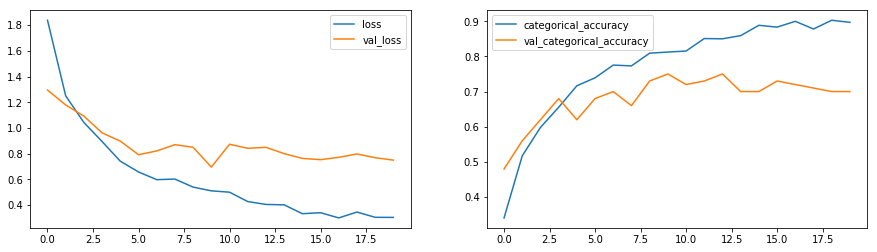

In [55]:
plot(history_model6)

###### For the above low memory foot print model, we get the best validation accuracy of 75%

## Model 7 - Reducing the number of parameters again

In [8]:
class ModelConv3D7(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [9]:
conv_3d7=ModelConv3D7()
conv_3d7.initialize_path(project_folder)
conv_3d7.initialize_image_properties(image_height=120,image_width=120)
conv_3d7.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d7_model=conv_3d7.define_model(dense_neurons=64,dropout=0.25)
conv_3d7_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
activation_2 (Activation)    (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 60, 60, 32)     128       
__________

In [10]:
print("Total Params:", conv_3d7_model.count_params())
history_model7=conv_3d7.train_model(conv_3d7_model,augment_data=True)

Total Params: 504709
Epoch 1/25
34/34 [==============================] - 195s 6s/step - loss: 1.7510 - categorical_accuracy: 0.3775 - val_loss: 1.8949 - val_categorical_accuracy: 0.3100

Epoch 00001: val_loss improved from inf to 1.89489, saving model to model_init_2020-09-1915_04_21.664811/model-00001-1.76364-0.37029-1.89489-0.31000.h5
Epoch 2/25
34/34 [==============================] - 85s 3s/step - loss: 1.2973 - categorical_accuracy: 0.5118 - val_loss: 1.1788 - val_categorical_accuracy: 0.6300

Epoch 00002: val_loss improved from 1.89489 to 1.17883, saving model to model_init_2020-09-1915_04_21.664811/model-00002-1.24278-0.52036-1.17883-0.63000.h5
Epoch 3/25
34/34 [==============================] - 86s 3s/step - loss: 1.0024 - categorical_accuracy: 0.6144 - val_loss: 1.1219 - val_categorical_accuracy: 0.6500

Epoch 00003: val_loss improved from 1.17883 to 1.12195, saving model to model_init_2020-09-1915_04_21.664811/model-00003-0.97331-0.62142-1.12195-0.65000.h5
Epoch 4/25
34/34 [=

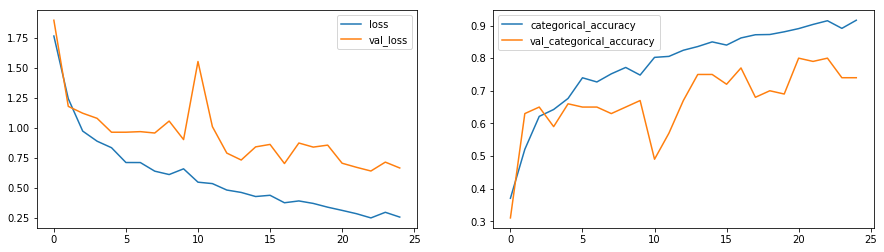

In [11]:
plot(history_model7)

###### For the above low memory foot print model the best validation accuracy of 80%

## Model 8 - CNN- LSTM Model

In [35]:
class RNNCNN1(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
       # model.add(TimeDistributed(BatchNormalization()))
       # model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [13]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn1.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 18, 30, 30, 64)    18496     
__________

In [14]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model8=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

Total Params: 1657445
Epoch 1/20
34/34 [==============================] - 157s 5s/step - loss: 1.4130 - categorical_accuracy: 0.3988 - val_loss: 1.1787 - val_categorical_accuracy: 0.5400

Epoch 00001: val_loss improved from inf to 1.17868, saving model to model_init_2020-09-1915_41_45.034030/model-00001-1.41571-0.40045-1.17868-0.54000.h5
Epoch 2/20
34/34 [==============================] - 92s 3s/step - loss: 1.1512 - categorical_accuracy: 0.5099 - val_loss: 1.6599 - val_categorical_accuracy: 0.3300

Epoch 00002: val_loss did not improve from 1.17868
Epoch 3/20
34/34 [==============================] - 93s 3s/step - loss: 1.0696 - categorical_accuracy: 0.5581 - val_loss: 1.1766 - val_categorical_accuracy: 0.5400

Epoch 00003: val_loss improved from 1.17868 to 1.17664, saving model to model_init_2020-09-1915_41_45.034030/model-00003-1.07679-0.55128-1.17664-0.54000.h5
Epoch 4/20
34/34 [==============================] - 92s 3s/step - loss: 0.9406 - categorical_accuracy: 0.6071 - val_loss: 1

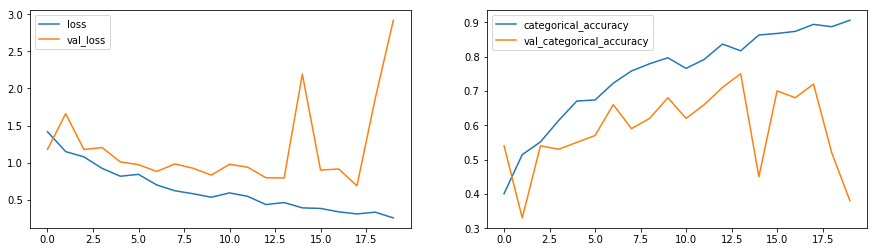

In [15]:
plot(history_model8)

##### For CNN - LSTM model we get a best validation accuracy of 72%

As we see more cases of overfitting, lets augment the data with ***slight rotation*** as well and run the same set of models again

## Apply some data augmentation and check the model performance.

In [10]:
class ModelBuilderMoreAugmentation(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass
    
    

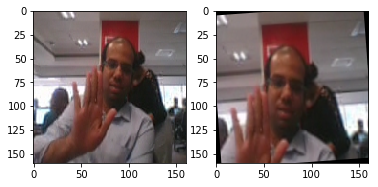

In [17]:
class Test(ModelBuilderMoreAugmentation):
    def define_model(self):
        pass

test_generator=Test()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,29,:,:,:])   
axes[1].imshow(batch_data[3,29,:,:,:])   

## Model 9 with Augmentation
>> ### (3,3,3) Filter & 160x160 Image resolution - similar to Model 2

In [18]:
class ModelConv3D9(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [19]:
conv_3d9=ModelConv3D9()
conv_3d9.initialize_path(project_folder)
conv_3d9.initialize_image_properties(image_height=160,image_width=160)
conv_3d9.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=20)
conv_3d9_model=conv_3d9.define_model(dense_neurons=256,dropout=0.5)
conv_3d9_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_5 (Activation)    (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_6 (Activation)    (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 10, 80, 80, 32)    128       
__________

In [20]:
print("Total Params:", conv_3d9_model.count_params())
history_model9=conv_3d9.train_model(conv_3d9_model,augment_data=True)

Total Params: 3638981
Epoch 1/20
34/34 [==============================] - 163s 5s/step - loss: 2.0859 - categorical_accuracy: 0.3414 - val_loss: 1.0632 - val_categorical_accuracy: 0.5600

Epoch 00001: saving model to model_init_2020-09-1916_14_09.092491/model-00001-2.09146-0.34163-1.06324-0.56000.h5
Epoch 2/20
34/34 [==============================] - 120s 4s/step - loss: 1.6782 - categorical_accuracy: 0.4352 - val_loss: 0.8954 - val_categorical_accuracy: 0.6400

Epoch 00002: saving model to model_init_2020-09-1916_14_09.092491/model-00002-1.63712-0.44193-0.89539-0.64000.h5
Epoch 3/20
34/34 [==============================] - 123s 4s/step - loss: 1.3370 - categorical_accuracy: 0.5353 - val_loss: 0.8951 - val_categorical_accuracy: 0.6300

Epoch 00003: saving model to model_init_2020-09-1916_14_09.092491/model-00003-1.34299-0.52790-0.89515-0.63000.h5
Epoch 4/20
34/34 [==============================] - 123s 4s/step - loss: 1.1853 - categorical_accuracy: 0.5817 - val_loss: 0.8342 - val_categ

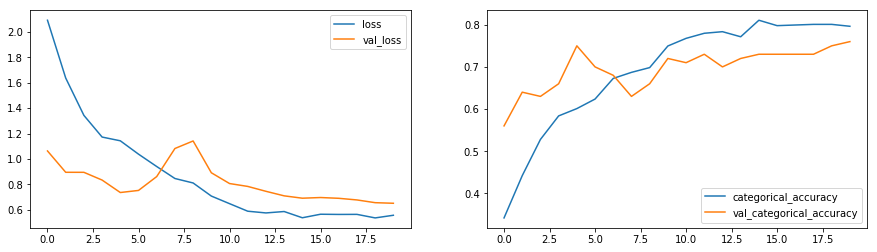

In [21]:
plot(history_model9)

## Model 10 with Augmentation
>> ### (2,2,2) Filter  & 120x120 Image resolution - similar to Model 3

In [22]:
class ModelConv3D10(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [23]:
conv_3d10=ModelConv3D10()
conv_3d10.initialize_path(project_folder)
conv_3d10.initialize_image_properties(image_height=120,image_width=120)
conv_3d10.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=25)
conv_3d10_model=conv_3d10.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d10_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_9 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_10 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 8, 60, 60, 32)     128       
__________

In [24]:
print("Total Params:", conv_3d10_model.count_params())
history_model10=conv_3d10.train_model(conv_3d10_model,augment_data=True)

Total Params: 1762613
Epoch 1/25
23/23 [==============================] - 84s 4s/step - loss: 2.1933 - categorical_accuracy: 0.3126 - val_loss: 1.2792 - val_categorical_accuracy: 0.5500

Epoch 00001: saving model to model_init_2020-09-1916_55_45.352902/model-00001-2.16330-0.31825-1.27915-0.55000.h5
Epoch 2/25
23/23 [==============================] - 75s 3s/step - loss: 1.5960 - categorical_accuracy: 0.4683 - val_loss: 1.0254 - val_categorical_accuracy: 0.6400

Epoch 00002: saving model to model_init_2020-09-1916_55_45.352902/model-00002-1.57864-0.47360-1.02540-0.64000.h5
Epoch 3/25
23/23 [==============================] - 78s 3s/step - loss: 1.3685 - categorical_accuracy: 0.5306 - val_loss: 0.9605 - val_categorical_accuracy: 0.6400

Epoch 00003: saving model to model_init_2020-09-1916_55_45.352902/model-00003-1.38308-0.51885-0.96045-0.64000.h5
Epoch 4/25
23/23 [==============================] - 79s 3s/step - loss: 1.2176 - categorical_accuracy: 0.5569 - val_loss: 0.9050 - val_categoric

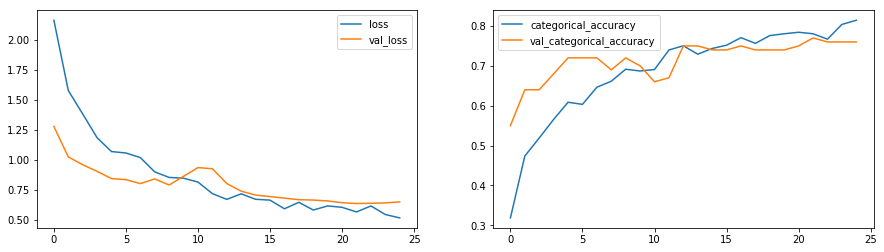

In [25]:
plot(history_model10)

## Model 11 with Augmentation
>> ### Adding more layers - Similar to model 4

In [26]:
class ModelConv3D11(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [27]:
conv_3d11=ModelConv3D11()
conv_3d11.initialize_path(project_folder)
conv_3d11.initialize_image_properties(image_height=120,image_width=120)
conv_3d11.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d11_model=conv_3d11.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d11_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_13 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_13 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_14 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 8, 60, 60, 16)     0         
__________

In [28]:
print("Total Params:", conv_3d11_model.count_params())
history_model11=conv_3d11.train_model(conv_3d11_model,augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 [==============================] - 110s 3s/step - loss: 2.1025 - categorical_accuracy: 0.3241 - val_loss: 2.2726 - val_categorical_accuracy: 0.3600

Epoch 00001: saving model to model_init_2020-09-1917_29_22.371100/model-00001-2.08290-0.32805-2.27259-0.36000.h5
Epoch 2/25
34/34 [==============================] - 93s 3s/step - loss: 1.4464 - categorical_accuracy: 0.4967 - val_loss: 1.0221 - val_categorical_accuracy: 0.6400

Epoch 00002: saving model to model_init_2020-09-1917_29_22.371100/model-00002-1.46283-0.49246-1.02212-0.64000.h5
Epoch 3/25
34/34 [==============================] - 93s 3s/step - loss: 1.2557 - categorical_accuracy: 0.5684 - val_loss: 0.9071 - val_categorical_accuracy: 0.6500

Epoch 00003: saving model to model_init_2020-09-1917_29_22.371100/model-00003-1.24725-0.56184-0.90714-0.65000.h5
Epoch 4/25
34/34 [==============================] - 93s 3s/step - loss: 1.1257 - categorical_accuracy: 0.6107 - val_loss: 0.9904 - val_categori

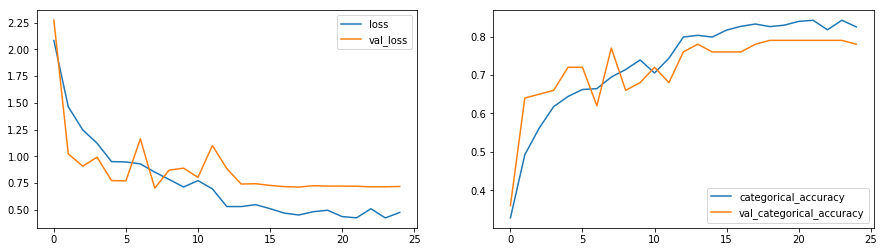

In [29]:
plot(history_model11)

## Model 12 with Augmentation
>> ### Adding dropouts - Similar to Model 5

In [30]:
class ModelConv3D12(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [31]:
conv_3d12=ModelConv3D12()
conv_3d12.initialize_path(project_folder)
conv_3d12.initialize_image_properties(image_height=120,image_width=120)
conv_3d12.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d12_model=conv_3d12.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d12_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_21 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_21 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_22 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_22 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_35 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_17 (MaxPooling (None, 8, 60, 60, 16)     0         
__________

In [32]:
print("Total Params:", conv_3d12_model.count_params())
history_model12=conv_3d12.train_model(conv_3d12_model,augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 [==============================] - 103s 3s/step - loss: 2.0152 - categorical_accuracy: 0.3153 - val_loss: 1.6244 - val_categorical_accuracy: 0.4200

Epoch 00001: saving model to model_init_2020-09-1918_08_30.253529/model-00001-2.02176-0.31071-1.62436-0.42000.h5
Epoch 2/25
34/34 [==============================] - 93s 3s/step - loss: 1.6658 - categorical_accuracy: 0.4036 - val_loss: 1.8927 - val_categorical_accuracy: 0.3700

Epoch 00002: saving model to model_init_2020-09-1918_08_30.253529/model-00002-1.62612-0.40950-1.89272-0.37000.h5
Epoch 3/25
34/34 [==============================] - 93s 3s/step - loss: 1.4409 - categorical_accuracy: 0.4669 - val_loss: 2.3656 - val_categorical_accuracy: 0.3600

Epoch 00003: saving model to model_init_2020-09-1918_08_30.253529/model-00003-1.44898-0.45777-2.36563-0.36000.h5
Epoch 4/25
34/34 [==============================] - 93s 3s/step - loss: 1.2869 - categorical_accuracy: 0.4985 - val_loss: 2.7601 - val_categori

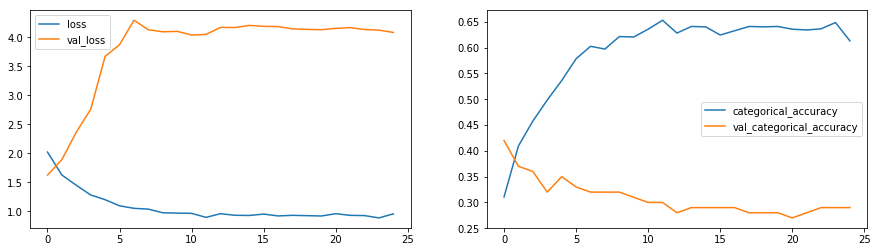

In [33]:
plot(history_model12)

Model is overfitting badly !!

## Model 13 with Augmentation
>> ### Reducing network parameters - Similar to Model 6

In [11]:
class ModelConv3D13(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [12]:
conv_3d13=ModelConv3D13()
conv_3d13.initialize_path(project_folder)
conv_3d13.initialize_image_properties(image_height=100,image_width=100)
conv_3d13.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d13_model=conv_3d13.define_model(dense_neurons=128,dropout=0.25)
conv_3d13_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 16, 100, 100, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 8, 50, 50, 32)     4128      
_________________________________________________________________
activation_2 (Activation)    (None, 8, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 50, 50, 32)     128       
__________

In [13]:
print("Total Params:", conv_3d13_model.count_params())
history_model13=conv_3d13.train_model(conv_3d13_model,augment_data=True)

Total Params: 696645
Epoch 1/25
34/34 [==============================] - 194s 6s/step - loss: 1.8617 - categorical_accuracy: 0.3425 - val_loss: 1.2882 - val_categorical_accuracy: 0.5300

Epoch 00001: saving model to model_init_2020-09-2001_34_58.899638/model-00001-1.87847-0.33861-1.28818-0.53000.h5
Epoch 2/25
34/34 [==============================] - 82s 2s/step - loss: 1.2603 - categorical_accuracy: 0.5287 - val_loss: 0.9931 - val_categorical_accuracy: 0.6300

Epoch 00002: saving model to model_init_2020-09-2001_34_58.899638/model-00002-1.24014-0.52941-0.99314-0.63000.h5
Epoch 3/25
34/34 [==============================] - 82s 2s/step - loss: 1.0515 - categorical_accuracy: 0.5909 - val_loss: 1.0368 - val_categorical_accuracy: 0.6600

Epoch 00003: saving model to model_init_2020-09-2001_34_58.899638/model-00003-1.03343-0.59729-1.03678-0.66000.h5
Epoch 4/25
34/34 [==============================] - 82s 2s/step - loss: 0.8656 - categorical_accuracy: 0.6685 - val_loss: 0.9722 - val_categoric

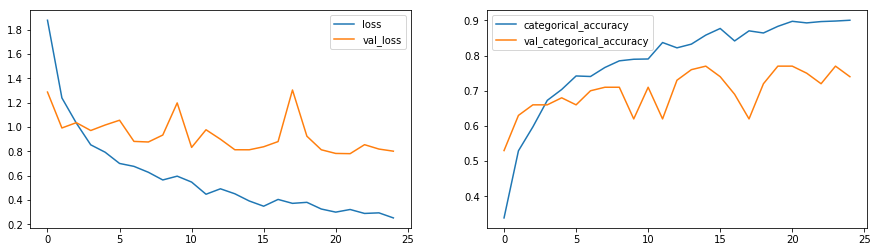

In [14]:
plot(history_model13)

## Model 14 with Augmentation
>> ###  Reducing network parameters again - Similar to model 7

In [15]:
class ModelConv3D14(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [16]:
conv_3d14=ModelConv3D14()
conv_3d14.initialize_path(project_folder)
conv_3d14.initialize_image_properties(image_height=120,image_width=120)
conv_3d14.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d14_model=conv_3d14.define_model(dense_neurons=64,dropout=0.25)
conv_3d14_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_5 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
activation_6 (Activation)    (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 8, 60, 60, 32)     128       
__________

In [17]:
print("Total Params:", conv_3d14_model.count_params())
history_model14=conv_3d14.train_model(conv_3d14_model,augment_data=True)

Total Params: 504709
Epoch 1/25
34/34 [==============================] - 94s 3s/step - loss: 1.7444 - categorical_accuracy: 0.3576 - val_loss: 1.2976 - val_categorical_accuracy: 0.5300

Epoch 00001: saving model to model_init_2020-09-2002_10_40.243444/model-00001-1.75020-0.35822-1.29756-0.53000.h5
Epoch 2/25
34/34 [==============================] - 85s 2s/step - loss: 1.2633 - categorical_accuracy: 0.4956 - val_loss: 1.2341 - val_categorical_accuracy: 0.5600

Epoch 00002: saving model to model_init_2020-09-2002_10_40.243444/model-00002-1.25745-0.50377-1.23407-0.56000.h5
Epoch 3/25
34/34 [==============================] - 87s 3s/step - loss: 1.1165 - categorical_accuracy: 0.5552 - val_loss: 0.9752 - val_categorical_accuracy: 0.6700

Epoch 00003: saving model to model_init_2020-09-2002_10_40.243444/model-00003-1.10641-0.55656-0.97524-0.67000.h5
Epoch 4/25
34/34 [==============================] - 87s 3s/step - loss: 0.9797 - categorical_accuracy: 0.6192 - val_loss: 0.8047 - val_categorica

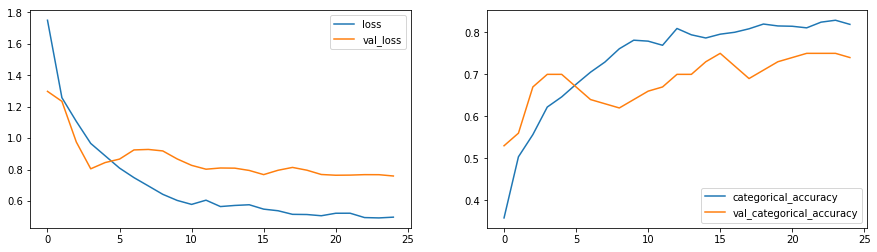

In [18]:
plot(history_model14)

## Model 15 with Augmentation
>> ### CNN LSTM with GRU - Similar to Model 8

In [19]:
class RNNCNN2(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [20]:
rnn_cnn2=RNNCNN2()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn2.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 18, 30, 30, 64)    18496     
__________

In [21]:
print("Total Params:", rnn_cnn2_model.count_params())
history_model15=rnn_cnn2.train_model(rnn_cnn2_model,augment_data=True)

Total Params: 2573541
Epoch 1/20
34/34 [==============================] - 157s 5s/step - loss: 1.4994 - categorical_accuracy: 0.3528 - val_loss: 1.1437 - val_categorical_accuracy: 0.4900

Epoch 00001: saving model to model_init_2020-09-2002_47_01.023448/model-00001-1.49283-0.35747-1.14367-0.49000.h5
Epoch 2/20
34/34 [==============================] - 96s 3s/step - loss: 1.0870 - categorical_accuracy: 0.5732 - val_loss: 1.0175 - val_categorical_accuracy: 0.6200

Epoch 00002: saving model to model_init_2020-09-2002_47_01.023448/model-00002-1.09095-0.57089-1.01755-0.62000.h5
Epoch 3/20
34/34 [==============================] - 98s 3s/step - loss: 0.8882 - categorical_accuracy: 0.6748 - val_loss: 1.1299 - val_categorical_accuracy: 0.5600

Epoch 00003: saving model to model_init_2020-09-2002_47_01.023448/model-00003-0.89533-0.66667-1.12988-0.56000.h5
Epoch 4/20
34/34 [==============================] - 97s 3s/step - loss: 0.7216 - categorical_accuracy: 0.7520 - val_loss: 0.8284 - val_categori

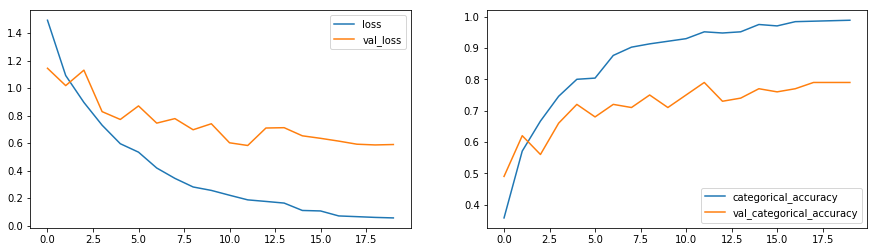

In [22]:
plot(history_model15)

### We have noticed that when we do more augmentation 

>> - Leading to high overfitting . 
>> - At the sametime there is not much improvement on accuracy.

## Model 16 - Let us bring in Transfer Learning !! :)
__(Optional)__

In [23]:
# importing the MobileNet model due to it's lightweight architecture and high speed performance as compared 
# to other heavy-duty models like VGG16, Alexnet, InceptionV3 etc. Also, we are now also running on low disk space 
# in the nimblebox.ai platform. 

from keras.applications import mobilenet

In [24]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        
        for layer in model.layers:
            layer.trainable = False
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

17227776/17225924 [==============================] - 2s 0us/step


In [25]:
rnn_cnn_tl=RNNCNN_TL()
rnn_cnn_tl.initialize_path(project_folder)
rnn_cnn_tl.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl_model=rnn_cnn_tl.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_14 (TimeDis (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_15 (TimeDis (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_16 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_17 (TimeDis (None, 16, 1024)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               590336    
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
__________

In [26]:
print("Total Params:", rnn_cnn_tl_model.count_params())
history_model16=rnn_cnn_tl.train_model(rnn_cnn_tl_model,augment_data=True)

Total Params: 3840453
Epoch 1/20
133/133 [==============================] - 88s 665ms/step - loss: 1.4483 - categorical_accuracy: 0.3784 - val_loss: 1.3499 - val_categorical_accuracy: 0.4900

Epoch 00001: saving model to model_init_2020-09-2003_20_43.390000/model-00001-1.44895-0.37858-1.34993-0.49000.h5
Epoch 2/20
133/133 [==============================] - 80s 599ms/step - loss: 1.1508 - categorical_accuracy: 0.5223 - val_loss: 1.1566 - val_categorical_accuracy: 0.5100

Epoch 00002: saving model to model_init_2020-09-2003_20_43.390000/model-00002-1.14999-0.52338-1.15659-0.51000.h5
Epoch 3/20
133/133 [==============================] - 81s 612ms/step - loss: 1.0364 - categorical_accuracy: 0.5754 - val_loss: 1.1712 - val_categorical_accuracy: 0.5200

Epoch 00003: saving model to model_init_2020-09-2003_20_43.390000/model-00003-1.03480-0.57617-1.17115-0.52000.h5
Epoch 4/20
133/133 [==============================] - 82s 617ms/step - loss: 0.9011 - categorical_accuracy: 0.6496 - val_loss: 1.

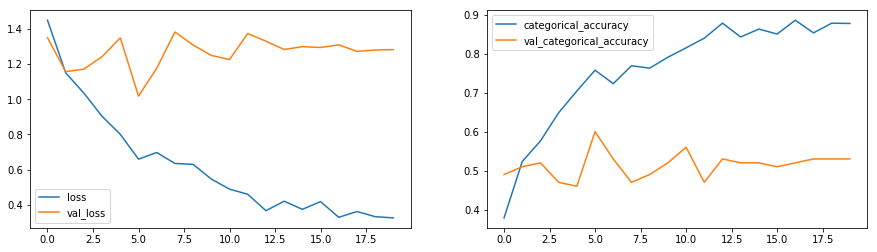

In [27]:
plot(history_model16)

##### We are not training the mobilenet weights and we see validation accuracy is very poor. Let's train them as well and observe if there is performance improvement

## Model 17 - Transfer Learning with GRU and training all weights
__(Optional)__

In [28]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL2(ModelBuilderMoreAugmentation):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [29]:
rnn_cnn_tl2=RNNCNN_TL2()
rnn_cnn_tl2.initialize_path(project_folder)
rnn_cnn_tl2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl2.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl2_model=rnn_cnn_tl2.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl2_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_18 (TimeDis (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_19 (TimeDis (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_20 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_21 (TimeDis (None, 16, 1024)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               442752    
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               16512     
__________

In [30]:
print("Total Params:", rnn_cnn_tl2_model.count_params())
history_model17=rnn_cnn_tl2.train_model(rnn_cnn_tl2_model,augment_data=True)

Total Params: 3692869
Epoch 1/20
133/133 [==============================] - 100s 756ms/step - loss: 1.2254 - categorical_accuracy: 0.4877 - val_loss: 0.7937 - val_categorical_accuracy: 0.6700

Epoch 00001: saving model to model_init_2020-09-2003_48_15.009100/model-00001-1.22670-0.48718-0.79370-0.67000.h5
Epoch 2/20
133/133 [==============================] - 88s 662ms/step - loss: 0.7002 - categorical_accuracy: 0.7135 - val_loss: 0.7699 - val_categorical_accuracy: 0.6900

Epoch 00002: saving model to model_init_2020-09-2003_48_15.009100/model-00002-0.69836-0.71418-0.76986-0.69000.h5
Epoch 3/20
133/133 [==============================] - 90s 679ms/step - loss: 0.5576 - categorical_accuracy: 0.7952 - val_loss: 0.7089 - val_categorical_accuracy: 0.7200

Epoch 00003: saving model to model_init_2020-09-2003_48_15.009100/model-00003-0.55594-0.79563-0.70885-0.72000.h5
Epoch 4/20
133/133 [==============================] - 91s 683ms/step - loss: 0.4337 - categorical_accuracy: 0.8353 - val_loss: 0

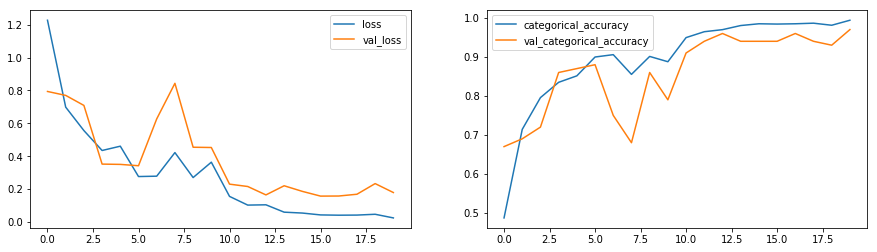

In [31]:
plot(history_model17)

### Awesome results! 99% Training accuracy and 97% validation accuracy :)

# Consolidated Final Models

# Refer to the write-up for the consolidated final models. 

## After doing all the experiments, we finalized Model 8 - CNN+LSTM, which performed well.
__Reason:__

__- (Training Accuracy : 89%, Validation Accuracy : 72%)__

__- Number of Parameters(1,657,445)less according to other models performance__

__- Learning rate gradually decreacing after 14 Epoch__


__The best weights of CNN-LSTM: model-00014-0.45959-0.81674-0.79221-0.75000.h5 (19 MB). we considered this weight for model testing, Let's have look at the performance below__


# Loading model and Testing

In [33]:
import time
from keras.models import load_model
model = load_model('model_init_2020-09-1915_41_45.034030/model-00014-0.45959-0.81674-0.79221-0.75000.h5')

In [36]:
test_generator=RNNCNN1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=120,image_width=120)
test_generator.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=False)
batch_data, batch_labels=next(g)

In [37]:
batch_labels

array([[1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [38]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

[4 2 3 3 2 0 0 4 0 2 3 0 3 1 2 2 1 3 1 3]


             
# <font color = blue> Contributors : </font>                                                           
# 1. Rajesh Suguru - Group Facilitator                                  
# 2. Vigneswar Ramayi                                                         